# Cancer🔬 Classification: Baseline with ⚡`lightning`

**It is continuation of EDA: https://www.kaggle.com/code/jirkaborovec/cancer-subtype-explore-data-images**

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/UBC-OCEAN/"
DATASET_IMAGES = "/kaggle/input/cancer-subtype-eda-load-wsi-prune-bg/train_thumbnails/"

## Checkout some labels

In [2]:
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
# labels = list(df_train["label"].unique())
print(f"Dataset/train size: {len(df_train)}")
display(df_train.head())

Dataset/train size: 538


,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


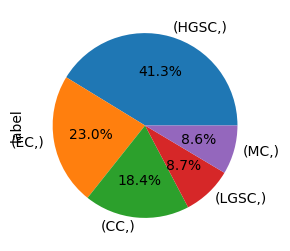

In [3]:
_= df_train[["label"]].value_counts().plot.pie(autopct='%1.1f%%', ylabel="label", figsize=(3,3))

### Show some samples 🖼️ per class

Note that not all images has thumbnails

In [4]:
df_train["path_thumbnail"] = df_train['image_id'].apply(lambda id: f"{id}_thumbnail.png")
df_train["thumbnail_exists"] = df_train['path_thumbnail'].apply(
    lambda pth: os.path.isfile(os.path.join(DATASET_IMAGES, pth)))
display(df_train.head())
df_train = df_train[df_train["thumbnail_exists"] == True]
print(f"size: {len(df_train)}")

,image_id,label,image_width,image_height,is_tma,path_thumbnail,thumbnail_exists
0,4,HGSC,23785,20008,False,4_thumbnail.png,True
1,66,LGSC,48871,48195,False,66_thumbnail.png,True
2,91,HGSC,3388,3388,True,91_thumbnail.png,True
3,281,LGSC,42309,15545,False,281_thumbnail.png,True
4,286,EC,37204,30020,False,286_thumbnail.png,True


size: 538


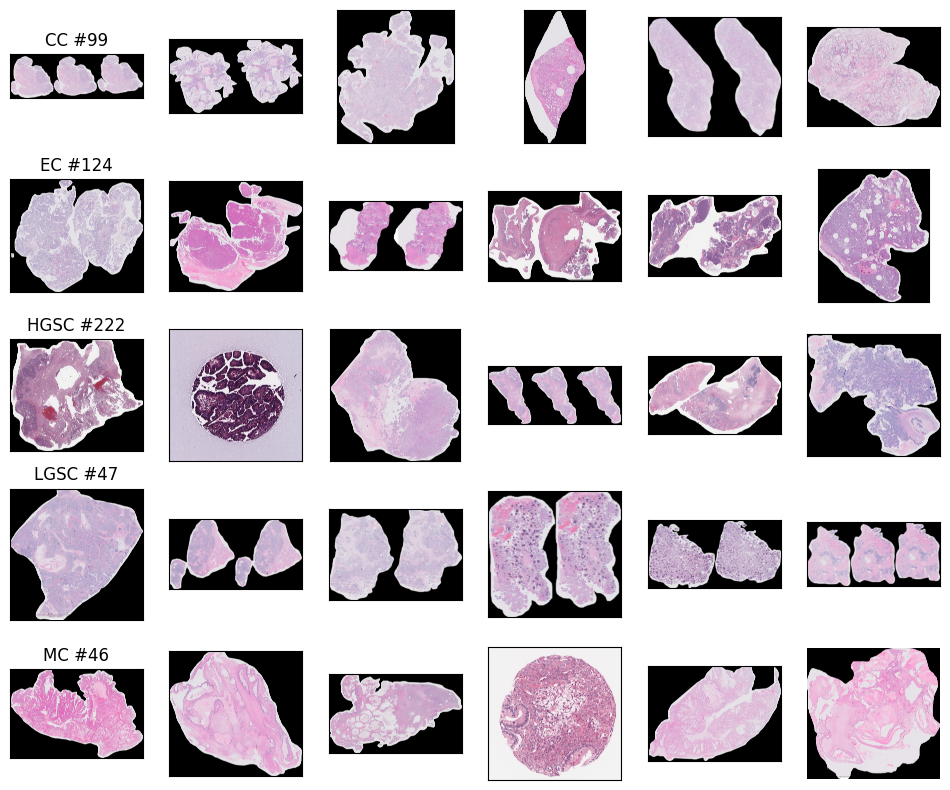

In [5]:
import matplotlib.pyplot as plt

nb_samples = 6
n, m = len(np.unique(df_train['label'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(df_train.groupby('label')):
    img_ids = list(df_['image_id'])
    for i in range(m):
        img_path = os.path.join(DATASET_IMAGES, f"{img_ids[i]}_thumbnail.png")
        img = plt.imread(img_path)
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
_= plt.axis('off')

## Data pre-processing

### Sacling down images

We could not fit this huge image size to any NEt so just as offline process lets downscale it to about 1024x1024

In [6]:
def prune_image_rows_cols(img, thr=0.001):
    # delete empty columns
    for l in reversed(range(img.shape[1])):
        if (np.sum(img[:, l]) / float(img.shape[0])) < thr:
            img = np.delete(img, l, 1)
    # delete empty rows
    for l in reversed(range(img.shape[0])):
        if (np.sum(img[l, :]) / float(img.shape[1])) < thr:
            img = np.delete(img, l, 0)
    return img

In [7]:
def prune_scale_image(img_path: str, out_dir: str, size: int = 1024) -> None:
    img = np.array(Image.open(img_path))
    img = prune_image_rows_cols(img)
    mask = np.sum(img[..., :3], axis=2) == 0
    img[mask, :] = 255
    img = Image.fromarray(img)
    img.thumbnail((size, size))
    img.save(os.path.join(out_dir, os.path.basename(img_path)))

In [8]:
import glob
from PIL import Image
from tqdm.auto import tqdm
from joblib import Parallel, delayed

! mkdir -p train_thumbnails
! rm -f train_thumbnails/*.png

ls = glob.glob(os.path.join(DATASET_IMAGES, '*.png'))
print(f"found images: {len(ls)}")

# for p_img in tqdm(ls):
#     prune_scale_image(p_img, "./train_thumbnails")
    
_= Parallel(n_jobs=4)(
    delayed(prune_scale_image)(p_img, "./train_thumbnails") for p_img in tqdm(ls)
)
ls = glob.glob(os.path.join("./train_thumbnails", '*.png'))
print(f"found images: {len(ls)}")

found images: 538


  0%|          | 0/538 [00:00<?, ?it/s]

found images: 538


### Color 🦩 normalizations

In [9]:
def _color_means(img_path):
    img = np.array(Image.open(img_path))
    if np.max(img) > 1.5:
        img = img / 255.0
    clr_mean = {i: np.mean(img[..., i]) for i in range(3)}
    clr_std = {i: np.std(img[..., i]) for i in range(3)}
    return clr_mean, clr_std

# os.path.join(DATASET_SMALL_FOLDER, "train_images")
ls_images = glob.glob(os.path.join("./train_thumbnails", "*.png"))
clr_mean_std = Parallel(n_jobs=os.cpu_count())(delayed(_color_means)(fn) for fn in tqdm(ls_images))

  0%|          | 0/538 [00:00<?, ?it/s]

In [10]:
img_color_mean = pd.DataFrame([c[0] for c in clr_mean_std]).describe()
display(img_color_mean.T)
img_color_std = pd.DataFrame([c[1] for c in clr_mean_std]).describe()
display(img_color_std.T)

img_color_mean = list(img_color_mean.T["mean"])
img_color_std = list(img_color_std.T["mean"])
print(f"{img_color_mean=}\n{img_color_std=}")

,count,mean,std,min,25%,50%,75%,max
0,538.0,0.889442,0.036619,0.684325,0.868408,0.892795,0.912935,0.973248
1,538.0,0.820875,0.050274,0.584903,0.794647,0.827446,0.855047,0.968550
2,538.0,0.886402,0.033381,0.699953,0.874796,0.892046,0.906543,0.975766


,count,mean,std,min,25%,50%,75%,max
0,538.0,0.101064,0.026599,0.051235,0.082776,0.097651,0.116948,0.233117
1,538.0,0.156377,0.035347,0.079651,0.132373,0.148813,0.171572,0.283007
2,538.0,0.098927,0.024028,0.058827,0.085030,0.093158,0.103256,0.242349


img_color_mean=[0.8894420586142375, 0.8208752169441305, 0.886401614138935]
img_color_std=[0.10106393015358608, 0.15637655015581306, 0.09892687853183288]


## Dataset & DataModule

Creating standard PyTorch dataset to define how the data shall be loaded and set representations. We define the sample pair as:
- RGB image
- one-hot lable encding

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

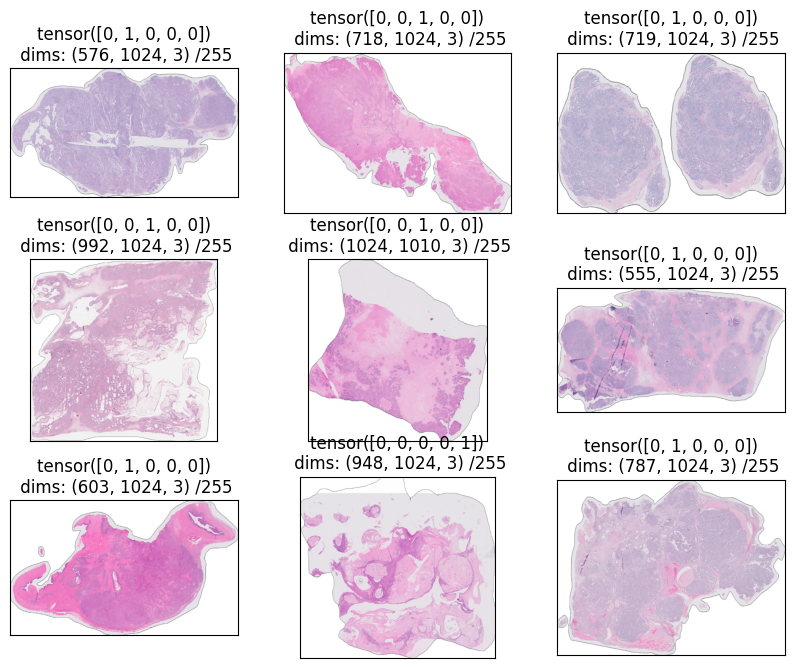

In [11]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class CancerThumbnailDataset(Dataset):
    split: float = 0.90

    def __init__(
        self,
        df_data,
        path_img_dir: str =  'train_thumbnails',
        transforms = None,
        mode: str = 'train',
        labels_lut = None
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = df_data
        self.labels_unique = sorted(self.data["label"].unique())
        self.labels_lut = labels_lut or {lb: i for i, lb in enumerate(self.labels_unique)}
        # shuffle data
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        # split dataset
        assert 0.0 <= self.split <= 1.0
        frac = int(self.split * len(self.data))
        self.data = self.data[:frac] if mode == 'train' else self.data[frac:]
        self.img_names = [f"{id}_thumbnail.png" for id in self.data["image_id"]]
        #print(f"missing: {sum([not os.path.isfile(os.path.join(self.path_img_dir, im))
        #                       for im in self.img_names])}")
        self.labels = list(self.data['label'])

    @property
    def num_classes(self) -> int:
        return len(self.labels_lut)

    def to_one_hot(self, label: str) -> tuple:
        one_hot = [0] * self.num_classes
        one_hot[self.labels_lut[label]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path), f"missing: {img_path}"
        img = plt.imread(img_path)[..., :3]
        if np.max(img) < 1.5:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        labels = self.to_one_hot(self.labels[idx])

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        #print(f"img dim: {img.shape}")
        return img, torch.tensor(labels).to(int)

    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = CancerThumbnailDataset(df_train)

# quick view
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"{lb}\n dims: {img.shape} /{np.max(img)}")

Let us define some standard image augmentaion procedures and color normalizations...

In [12]:
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

TRAIN_TRANSFORM = T.Compose([
    T.RandomRotation(45, fill=255),
    T.RandomCrop(512, pad_if_needed=True, padding_mode="reflect"),
    #T.RandomResizedCrop(512, interpolation=InterpolationMode.BICUBIC, antialias=True),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Normalize(img_color_mean, img_color_std),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.CenterCrop(512),
    T.ToTensor(),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Normalize(img_color_mean, img_color_std),  # custom
])

The DataModule include creating training and validation dataset with given split and feading it to particular data loaders...

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


training dataset: 484
validation dataset: 54
5
batch labels: tensor([1, 3, 1, 2, 1])
image size: torch.Size([3, 512, 512])


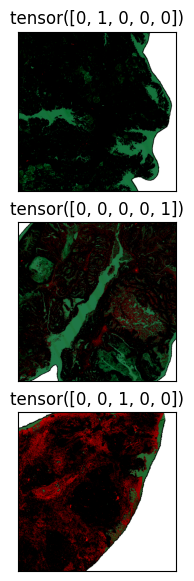

In [13]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class CancerSubtypeDM(pl.LightningDataModule):

    def __init__(
        self,
        df_data,
        path_img_dir: str = 'train_thumbnails',
        batch_size: int = 32,
        num_workers: int = None,
        train_transforms = TRAIN_TRANSFORM,
        valid_transforms = VALID_TRANSFORM
    ):
        super().__init__()
        self.df_data = df_data
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers or mproc.cpu_count()
        self.train_dataset = None
        self.valid_dataset = None
        self.train_transforms = train_transforms
        self.valid_transforms = valid_transforms

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return len(set(self.train_dataset.labels_unique + self.valid_dataset.labels_unique))

    def setup(self, stage=None):
        self.train_dataset = CancerThumbnailDataset(
            self.df_data, self.path_img_dir, mode='train', transforms=self.train_transforms)
        print(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = CancerThumbnailDataset(
            self.df_data, self.path_img_dir, mode='valid', transforms=self.valid_transforms,
            # as validation is subsampled it may happen that some labels are missing
            # and so created one-hot-encoding vector will be sorter
            labels_lut=self.train_dataset.labels_lut)
        print(f"validation dataset: {len(self.valid_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        pass

# ==============================
# ==============================

dm = CancerSubtypeDM(df_train, batch_size=8)
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        #print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

## CNN Model

We start with some standard CNN models taken from TIMM.
Then we define Ligthning module including training and validation step and configure optimizer/schedular.

- **Schedulers's example**: https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling
- **Schedulers explained**: https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863#5407
- **TIMM models**: https://github.com/huggingface/pytorch-image-models/blob/main/results/results-imagenet.csv

In [14]:
!pip install -q lion-pytorch adan-pytorch

In [16]:
import torch.nn as nn

class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [33]:
import timm
import torch
import torchvision
from adan_pytorch import Adan
from lion_pytorch import Lion
from torch.nn import functional as F
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

class ResNet_18(pl.LightningModule):
    
    def __init__(self, image_channels,lr: float = 1e-4):
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.num_classes = dm.num_classes
        self.train_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.val_f1_score = MulticlassF1Score(num_classes=self.num_classes)
        self.learn_rate = lr
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, dm.num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )
    
    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y.to(y_hat.dtype))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        lbs = torch.argmax(y, axis=1)
        #print(f"{lbs=} ?= {y_hat=}")
        loss = self.compute_loss(y_hat, y)
        #print(f"{y=} ?= {y_hat=} -> {loss=}")
        self.log("train_loss", loss, logger=True, prog_bar=True)
        #print(f"{lb=} ?= {y_hat=} -> {self.train_accuracy(y_hat, lbs)}")
        self.log("train_acc", self.train_accuracy(y_hat, lbs), logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        lbs = torch.argmax(y, axis=1)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, logger=True, prog_bar=False)
        self.log("valid_acc", self.val_accuracy(y_hat, lbs), logger=True, prog_bar=False)
        self.log("valid_f1", self.val_f1_score(y_hat, lbs), logger=True, prog_bar=True)

    def configure_optimizers(self):
        #optimizer = torch.optim.AdamW(self.parameters(), lr=self.learn_rate)
        #optimizer = Lion(self.parameters(), lr=self.learn_rate, weight_decay=1e-2)
        optimizer = Adan(self.parameters(), lr=self.learn_rate, betas=(0.02, 0.08, 0.01), weight_decay=0.02)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6, verbose=True)
        #scheduler = torch.optim.lr_scheduler.CyclicLR(
        #    optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=3, mode="triangular2", verbose=True)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    optimizer, max_lr=1e-4, steps_per_epoch=1, epochs=self.trainer.max_epochs)
        return [optimizer], [scheduler]
    
model = ResNet_18(3, 5e-4)
print(model)

ResNet_18(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (val_f1_score): MulticlassF1Score()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Training

We use Pytorch Lightning which allow us to drop all the boilet plate code and simplify all training just to use/call Trainer...

In [28]:
import torch.optim as optim

#define everything we need for training
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [34]:
logger = pl.loggers.CSVLogger(save_dir='logs/')
nb_epochs = 60 if torch.cuda.is_available() else 2

# ==============================

trainer = pl.Trainer(
    # fast_dev_run=True,
    # callbacks=[swa],
    logger=logger,
    max_epochs=nb_epochs,
    precision=16,
    accumulate_grad_batches=4,
    #val_check_interval=0.5,
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

training dataset: 484
validation dataset: 54
Adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9966e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9863e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9693e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9455e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9150e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.8779e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.8343e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7843e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7281e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.6657e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.5975e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.5235e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.4440e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.3591e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.2692e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1745e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.0752e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.9715e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.8639e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.7525e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.6377e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.5198e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.3991e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2760e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.1508e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0237e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8953e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.7658e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.6356e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5050e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.3744e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.2442e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.1147e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.9863e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.8592e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7340e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.6109e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.4902e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.3723e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2575e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.1461e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0385e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.3485e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.3552e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.4077e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5085e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.6602e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.8650e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.1252e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4427e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8194e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.2570e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7572e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.3211e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5015e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4522e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.0718e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.3668e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.3419e-06.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

Quick visualization of the training process...

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


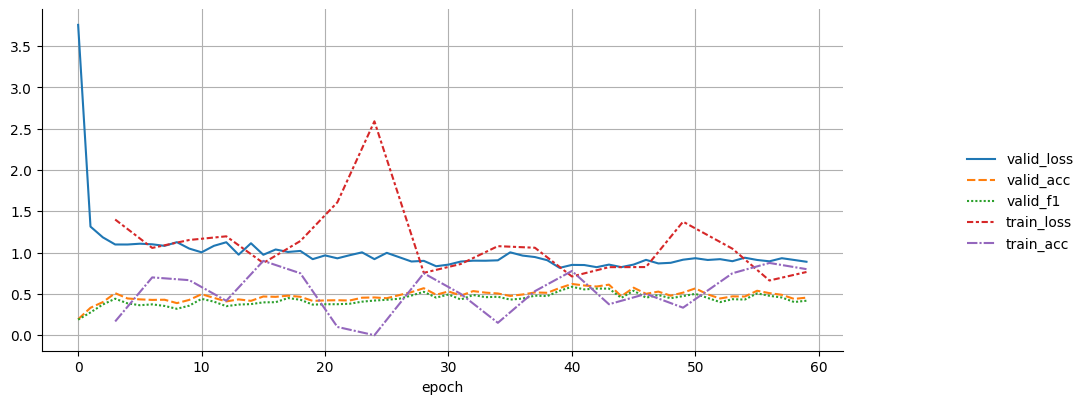

In [35]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
# plt.gca().set_yscale('log')
plt.grid()

Save the model!

In [36]:
trainer.save_checkpoint("image_classification_model.pt")

Inference coming in https://www.kaggle.com/code/jirkaborovec/cancer-subtype-lightning-torch-inference

In [37]:
import torch
from PIL import Image
from torch.utils.data import Dataset

class TilesFolderDataset(Dataset):

    def __init__(
        self,
        folder: str,
        image_ext: str =  '.png',
        transforms = None
    ):
        assert os.path.isdir(folder)
        self.transforms = transforms
        self.imgs = glob.glob(os.path.join(folder, "*" + image_ext))

    def __getitem__(self, idx: int) -> tuple:
        img_path = self.imgs[idx]
        assert os.path.isfile(img_path), f"missing: {img_path}"
        img = np.array(Image.open(img_path))[..., :3]
        # filter background
        mask = np.sum(img, axis=2) == 0
        img[mask, :] = 255
        if np.max(img) < 1.5:
            img = np.clip(img * 255, 0, 255).astype(np.uint8)
        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        #print(f"img dim: {img.shape}")
        return img

    def __len__(self) -> int:
        return len(self.imgs)

In [38]:
df_test = pd.read_csv(os.path.join(DATASET_FOLDER, "test.csv"))
# default label
df_test['label'] = ['HGSC'] * len(df_test)
# labels = list(df_train["label"].unique())
print(f"Dataset/test size: {len(df_test)}")
display(df_test.head())

Dataset/test size: 1


,image_id,image_width,image_height,label
0,41,28469,16987,HGSC


In [39]:
!cat /kaggle/input/UBC-OCEAN/sample_submission.csv

image_id,label
41,HGSC


In [55]:
!ls /kaggle/input/pyvips-python-and-deb-package-gpu
# intall the deb packages
!yes | dpkg -i --force-depends /kaggle/input/pyvips-python-and-deb-package-gpu/linux_packages/archives/*.deb
# install the python wrapper
!pip install pyvips -f /kaggle/input/pyvips-python-and-deb-package-gpu/python_packages/ --no-index

linux_packages	python_packages
Selecting previously unselected package apparmor.
(Reading database ... 113818 files and directories currently installed.)
Preparing to unpack .../apparmor_3.0.4-2ubuntu2.2_amd64.deb ...
Unpacking apparmor (3.0.4-2ubuntu2.2) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../autoconf_2.71-2_all.deb ...
Unpacking autoconf (2.71-2) ...
Selecting previously unselected package automake.
Preparing to unpack .../automake_13a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package autotools-dev.
Preparing to unpack .../autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
Selecting previously unselected package bzip2-doc.
Preparing to unpack .../bzip2-doc_1.0.8-5build1_all.deb ...
Unpacking bzip2-doc (1.0.8-5build1) ...
Selecting previously unselected package file.
Preparing to unpack .../file_13a5.41-3ubuntu0.1_amd64.deb ...
Unpacking file (1:5.41-3ubuntu0.1) ...
Sele

In [62]:
import pyvips
import random

DATASET_FOLDER = "/kaggle/input/UBC-OCEAN/"
IMAGES_FOLDER = "./test_tiles"

In [63]:
def extract_image_tiles(
    p_img, folder, size: int = 2048, scale: float = 0.5,
    drop_thr: float = 0.6, white_thr: int = 240, max_samples: int = 50
) -> list:
    name, _ = os.path.splitext(os.path.basename(p_img))
    im = pyvips.Image.new_from_file(p_img)
    w = h = size
    # https://stackoverflow.com/a/47581978/4521646
    idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
    # random subsample
    max_samples = max_samples if isinstance(max_samples, int) else int(len(idxs) * max_samples)
    random.shuffle(idxs)
    files = []
    for y, y_, x, x_ in idxs:
        # https://libvips.github.io/pyvips/vimage.html#pyvips.Image.crop
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        black_bg = np.sum(tile, axis=2) == 0
        tile[black_bg, :] = 255
        mask_bg = np.mean(tile, axis=2) > white_thr
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            #print(f"skip almost empty tile: {k:06}_{int(x_ / w)}-{int(y_ / h)}")
            continue
        p_img = os.path.join(folder, f"{int(x_ / w)}-{int(y_ / h)}.png")
        # print(tile.shape, tile.dtype, tile.min(), tile.max())
        new_size = int(size * scale), int(size * scale)
        Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img)
        files.append(p_img)
        # need to set counter check as some empty tiles could be skipped earlier
        if len(files) >= max_samples:
            break
    return files

In [64]:
import shutil
from torch.utils.data import DataLoader

model.eval()
model = model.cuda()

submission = []
for _, row in df_test.iterrows():
    row = dict(row)
    # prepare data - cut and load tiles
    folder_tiles = extract_image_tiles(
        os.path.join(DATASET_FOLDER, "test_images", f"{str(row['image_id'])}.png"),
        IMAGES_FOLDER, size=2048, scale=0.25)
    dataset = TilesFolderDataset(folder_tiles, transforms=VALID_TRANSFORM)
    if not len(dataset):
        print (f"seem no tiles were cut for `{folder_tiles}`")
        submission.append(row)
        continue
    dataloader = DataLoader(dataset, batch_size=4, num_workers=10, shuffle=False)
    # iterate over images and collect predictions
    preds = []
    for imgs in dataloader:
        #print(f"{imgs.shape}")
        with torch.no_grad():
            pred = model(imgs.cuda())
        preds += pred.cpu().numpy().tolist()
    print(f"Sum contrinution from all tiles: {np.sum(preds, axis=0)}")
    print(f"Max contribution over all tiles: {np.max(preds, axis=0)}")
    # decide label
    lb = np.argmax(np.sum(preds, axis=0))
    row['label'] = labels[lb]
    print(row)
    submission.append(row)
    # cleaning
    #shutil.rmtree(folder_tiles)
    os.system(f"rm -rf {folder_tiles}")

df_sub = pd.DataFrame(submission)

FileNotFoundError: [Errno 2] No such file or directory: './test_tiles/10-3.png'

In [ ]:
display(df_sub.head())
df_sub[["image_id", "label"]].to_csv("submission.csv", index=False)

! head submission.csv